# Implementation of Scheffe-Wald test on a Penalty analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CURRENT_PATH = Path.cwd()
MAIN_DIR = os.path.abspath(CURRENT_PATH.parent)
INPUT_DIR = os.path.join(CURRENT_PATH, 'data')

In [3]:
print(sys.path)

['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/sharon/.cache/pypoetry/virtualenvs/tesis-XL-UlrQA-py3.12/lib/python3.12/site-packages']


In [4]:
sys.path.append(MAIN_DIR)
sys

from scheffewald.multiple_comparisons import *
from scheffewald.visualization import *
from scheffewald.penalty_visualizations import *

# READ DATA

In [5]:
df = pd.read_csv(os.path.join(INPUT_DIR,'dt_compMult_formula_182.csv' ))

CONTEOS = (
    df
    .groupby(['atributo','nivel'])['sbj_num']
    .nunique()
    .reset_index()
)

In [6]:
OVERALL_LIKING = pd.read_csv(os.path.join(INPUT_DIR, 'dt_penalty.csv'))
OVERALL_LIKING['atributo'] = OVERALL_LIKING['atributo'].str.lower()
OVERALL_LIKING['nivel'] = OVERALL_LIKING['nivel'].str.upper()


In [7]:
def get_counts_for_attribute(df_counts: pd.DataFrame, atributo: str) -> list:
    """
    Extracts counts in order JAR, TL, TM for a given attribute.
    """
    counts = df_counts[df_counts['atributo'] == atributo].sort_values('nivel')
    return [
        counts[counts['nivel'] == 'JAR']['proporcion'].iloc[0],
        counts[counts['nivel'] == 'TL']['proporcion'].iloc[0],
        counts[counts['nivel'] == 'TM']['proporcion'].iloc[0]
    ]

(<Figure size 1500x800 with 4 Axes>,
 (<Axes: title={'center': 'Proporción de Respuestas'}, xlabel='nivel', ylabel='atributo'>,
  <Axes: title={'center': 'Diferencias Overall Liking\n(vs JAR)'}, ylabel='atributo'>))

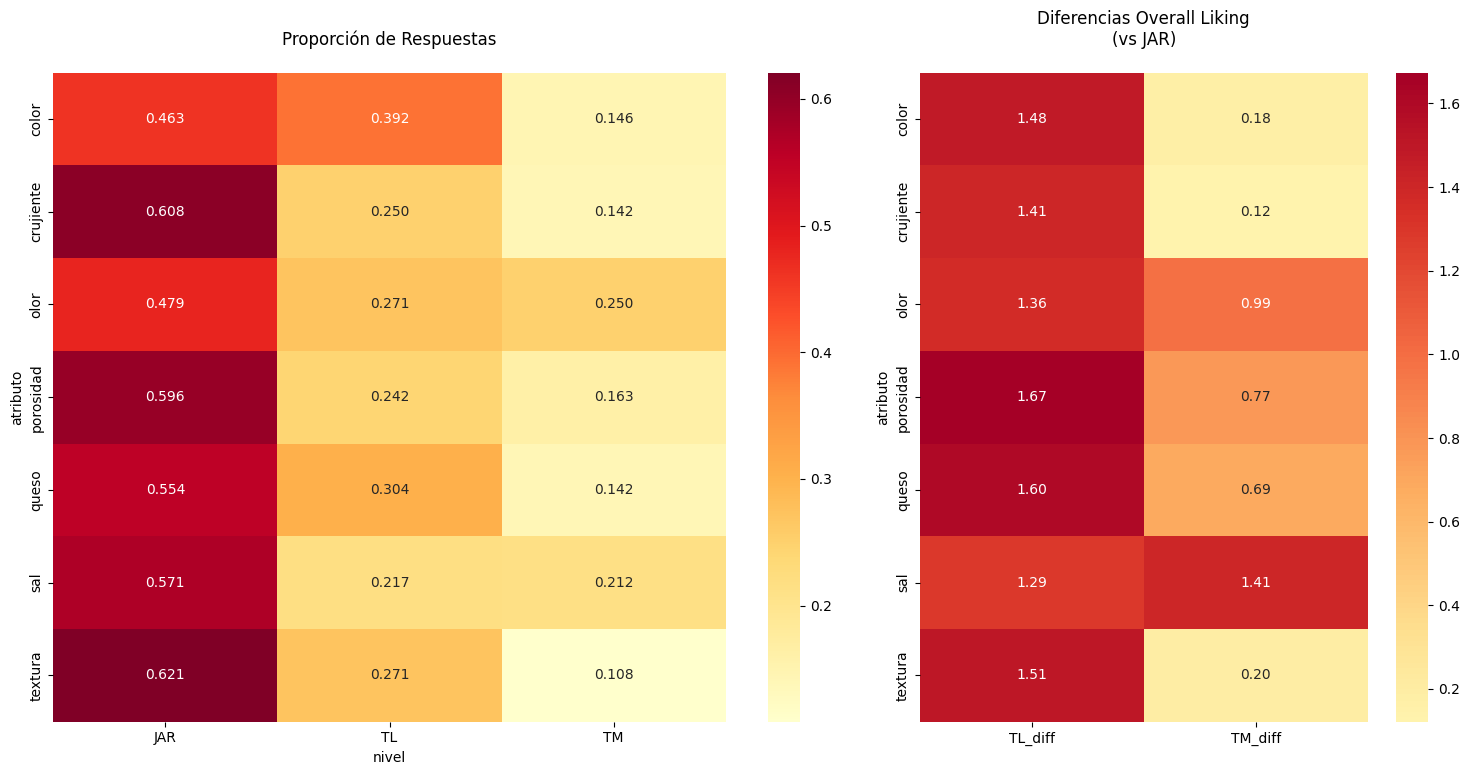

In [23]:
def plot_penalty_heatmap(df_ol: pd.DataFrame, df_counts: pd.DataFrame, title: str = "Penalty Analysis Heatmap"):
    """
    Creates a heatmap visualization using DataFrames.
    """
    # Prepare data for proportions
    prop_data = df_counts.pivot_table(
        values='sbj_num', 
        index='atributo', 
        columns='nivel', 
        aggfunc='sum'
    )
    
    # Calculate proportions
    total_responses = prop_data.sum(axis=1)
    prop_data = prop_data.div(total_responses, axis=0)
    
    # Calculate overall liking differences
    ol_data = df_ol.pivot_table(
        values='overall_liking',
        index='atributo',
        columns='nivel'
    )
    
    ol_diffs = pd.DataFrame({
        'TL_diff': ol_data['JAR'] - ol_data['TL'],
        'TM_diff': ol_data['JAR'] - ol_data['TM']
    })
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [1.5, 1]})
    
    # Plot proportions heatmap
    sns.heatmap(prop_data, 
                annot=True, 
                fmt='.3f',
                cmap='YlOrRd',
                ax=ax1)
    ax1.set_title('Proporción de Respuestas', pad=20)
    
    # Plot overall liking differences heatmap
    sns.heatmap(ol_diffs,
                annot=True,
                fmt='.2f',
                cmap='RdYlBu_r',
                center=0,
                ax=ax2)
    ax2.set_title('Diferencias Overall Liking\n(vs JAR)', pad=20)
    
    plt.suptitle(title, fontsize=14, y=1.05)
    plt.tight_layout()
    return fig, (ax1, ax2)

plot_penalty_heatmap(OVERALL_LIKING, CONTEOS, title="")

In [19]:
df_result = pd.DataFrame()
alpha = 0.20

# Matriz de contraste para las comparaciones
A = np.array([
    [1, -1, 0],   # JAR vs TL
    [1, 0, -1],   # JAR vs TM
])

for attribute in OVERALL_LIKING['atributo'].unique():
    counts = get_counts_for_attribute(OVERALL_LIKING, attribute)

    test = StatisticalTest(counts, alpha=alpha)

    bonf_result = test.bonferroni_confidence_intervals()
    #tukey_result = test.tukey_confidence_intervals()
    scheffe_result = test.scheffe_wald_test(A, fisher_correction=False)

    # Print results 
    print(str.upper(attribute),"*" * 70)
    print_test_results([scheffe_result, bonf_result])
    print("=" * 80)

    for method in [scheffe_result, bonf_result]:
        result = pd.DataFrame(format_test_results(method))
        result['attribute'] = attribute
        
        df_result = pd.concat([df_result, result]) 

df_result['p_i-p_j'] = df_result['p_i-p_j'].str.replace('0','JAR').str.replace('1','TL').str.replace('2','TM')


COLOR **********************************************************************

Scheffé-Wald results:
Overall p-value: 0.8668
Test statistic: 0.2858
Degrees of freedom: (df=2)

Pairwise Comparisons:
Category i	Category j	Difference	80.00% CI		p-value
--------------------------------------------------------------------------------
0		1		   0.071	[-1.907,  2.048]	nan
0		2		   0.317	[-1.213,  1.846]	nan

Bonferroni results:
Overall p-value: 1.0000
Test statistic: 0.5184
Degrees of freedom: (num=1, error=-1.1102230246251565e-16)

Pairwise Comparisons:
Category i	Category j	Difference	80.00% CI		p-value
--------------------------------------------------------------------------------
0		1		   0.071	[-1.209,  1.350]	1.0000
0		2		   0.317	[-0.804,  1.437]	1.0000
1		2		   0.246	[-0.859,  1.350]	1.0000
CRUJIENTE **********************************************************************

Scheffé-Wald results:
Overall p-value: 0.8141
Test statistic: 0.4114
Degrees of freedom: (df=2)

Pairwise Comparison

In [12]:
df_result.to_csv(os.path.join(MAIN_DIR, 'test_results.csv'))

In [20]:
colors = {'Scheffé-Wald': '#FF6B6B', 'Bonferroni': '#4ECDC4', 'Tukey': '#45B7D1'}
markers = {'Scheffé-Wald': 'o', 'Bonferroni': 's', 'Tukey': 'D'}

<Figure size 1500x1000 with 0 Axes>

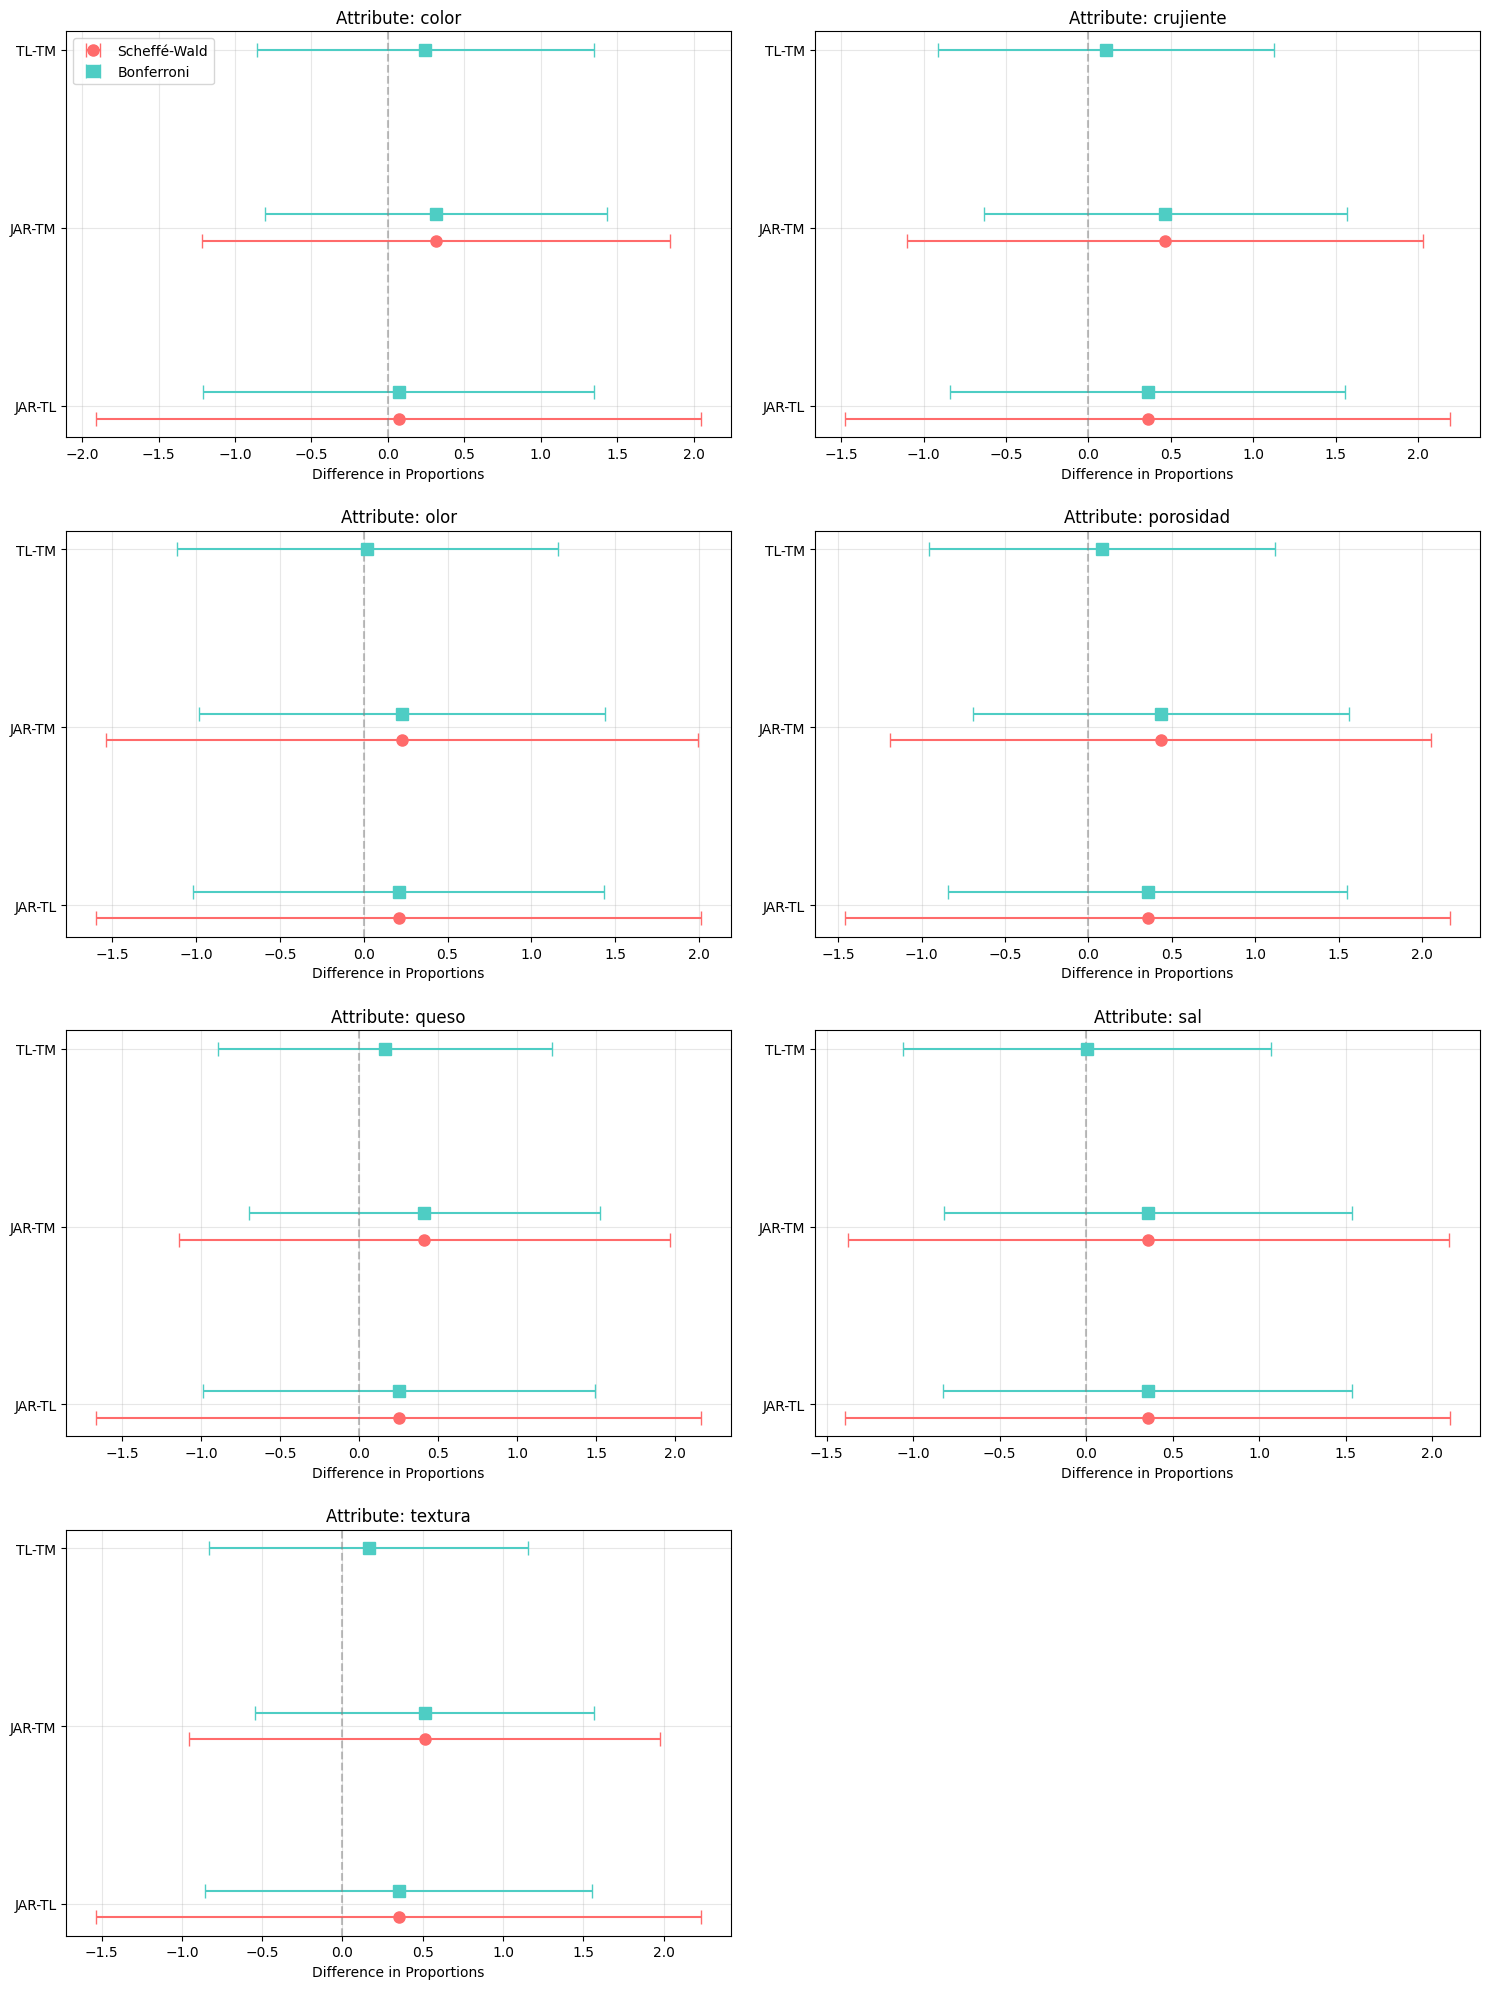

In [21]:

fig = plt.figure(figsize=(15, 10))
attributes = df_result['attribute'].unique()
n_attrs = len(attributes)
rows = int(np.ceil(n_attrs/2))
fig, axes = plt.subplots(rows, 2, figsize=(15, 5*rows))
axes = axes.flatten()

# Plot for each attribute
for idx, attr in enumerate(attributes):
    ax = axes[idx]
    attr_data = df_result[df_result['attribute'] == attr]
    
    y_positions = []
    y_labels = []
    current_pos = 0
    
    for comp in attr_data['p_i-p_j'].unique():
        comp_data = attr_data[attr_data['p_i-p_j'] == comp]
        
        # Add small offset for each test method
        for i, (_, row) in enumerate(comp_data.iterrows()):
            offset = i * 0.3 - (len(comp_data) - 1) * 0.15  # Center the methods
            y_pos = current_pos + offset
            
            ax.errorbar(
                x=row['diff'],
                y=y_pos,
                xerr=[[row['diff'] - row['conf_low']], [row['conf_hi'] - row['diff']]],
                fmt=markers[row['test']],
                color=colors[row['test']],
                capsize=5,
                label=row['test'] if current_pos == 0 else "",
                markersize=8
            )
            
        y_positions.append(current_pos)
        y_labels.append(comp)
        current_pos += 2.0  # Space between comparisons
    
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Difference in Proportions')
    ax.set_title(f'Attribute: {attr}')
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend()

# Remove empty subplots
for idx in range(len(attributes), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(h_pad=2.0, w_pad=2.0)
plt.show()

In [15]:
import subprocess

subprocess.run('jupyter nbconvert --to markdown implementation.ipynb', 
                   shell=True, 
                   stdout=subprocess.DEVNULL, 
                   stderr=subprocess.DEVNULL, 
                   check=True)

subprocess.run('pandoc --listings -f markdown -t latex implementation.md -o implementation.tex', 
                   shell=True, 
                   stdout=subprocess.DEVNULL, 
                   stderr=subprocess.DEVNULL, 
                   check=True)


CompletedProcess(args='pandoc --listings -f markdown -t latex implementation.md -o implementation.tex', returncode=0)